In [3]:
import pandas as pd
from bs4 import BeautifulSoup
import re
import random
import seaborn as sns
import numpy as np

In [4]:
random.seed(120)

In [764]:
df = pd.read_json("/shared/3/projects/benlitterer/podcastData/processed/floydMonth/floydMonthDataClean.jsonl", orient="records", lines=True)

In [ ]:
#metaDf = pd.read_json("/shared/3/projects/benlitterer/podcastData/processed/mayJune/mayJuneMetadata.jsonl", orient="record", lines=True)

In [ ]:
#if we don't already have entities for the transcripts and the descriptions, we need to add them... 

In [766]:
#just in case 
inDf = df

In [767]:
df = df.drop_duplicates(subset=["potentialOutPath"])

In [768]:
#do we want to work with podcasts where there's no description? or no transcript? let's say no for now
df = df.dropna(subset=["rssUrl", "transcript", "enclosure", "potentialOutPath", "epDescription", "podDescription",  "category1", "transEnts", "descEnts", "epDescEnts"])

In [ ]:
#odd that we only have 366,013 left after removing na's. Seems to be driven mostly by ents
#BUT: remember that many descriptions won't have entities  

In [770]:
#if either description or transcript has person entity and isn't none/na 
#then keep it
def hasPerson(inRow):
    #descTypes = inRow["DescType"]
    transTypes = inRow["transTypes"]

    #descHas = False
    transHas = False

    """
    if descTypes == descTypes and descTypes != None: 
        descHas = "PERSON" in descTypes
    """
        
    if transTypes == transTypes and transTypes != None: 
        transHas = "PERSON" in transTypes

    return transHas


#keep only those rows where we have a person in the description or the transcript
#TODO: modify this
df["hasPerson"] = df.apply(hasPerson, axis=1)
#df["hasPerson"] = df["transEnts"].apply(lambda x: x != None and x == x and len(x) > 0)

In [771]:
df.shape

(214244, 77)

In [772]:
df = df[df["hasPerson"] == True]

In [773]:
N_CATS=20
print(f'Unique Categories: {len(df["category1"].unique())}')
topCats = pd.DataFrame(df["category1"].value_counts()).reset_index().head(N_CATS)["category1"]
print(topCats)
topCats = list(topCats)

Unique Categories: 26
0       religion
1       business
2        society
3      education
4         sports
5           news
6         health
7           arts
8         comedy
9             tv
10       leisure
11         music
12    technology
13          kids
14       science
15       fiction
16       history
17    government
18    true crime
19         games
Name: category1, dtype: object


In [974]:
sampDf = df[df["category1"].apply(lambda x: x in topCats)]

In [975]:
SAMP_NUM = 100
SEED = 24
sampDf = sampDf.groupby(by="category1").apply(lambda x: x.sample(SAMP_NUM, random_state=SEED)).droplevel("category1")

/tmp/ipykernel_1749053/1225967707.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampDf = sampDf.groupby(by="category1").apply(lambda x: x.sample(SAMP_NUM, random_state=SEED)).droplevel("category1")


In [ ]:
def wrap(inStr): 
    i = 0 
    STEP = 20
    splitStr = inStr.split()
    outStr = ""
    while i < len(splitStr): 
        if i + STEP < len(splitStr):
            outStr += " ".join(splitStr[i:i+STEP]) + "\n"
        else: 
            outStr +=  " ".join(splitStr[i:]) + "\n"
        i += STEP
    print(outStr)

: 

In [910]:
#df.head()["transcript"]
#did some checks on data quality and things look better after 4-gram cleaning
#print(wrap(df.sample()["transcript"].item()))

In [911]:
def cleaner(inStr, LEN): 
    #clean out all tags in brackets or parenthesis
    inStr = re.sub(r'\[[^()]*\]\s*', '', inStr)
    inStr = re.sub(r'\([^()]*\)\s*', '', inStr)
    
    #replace paragraph breaks with new lines  
    inStr = re.sub("</p>",". ", inStr)
    inStr = re.sub("</br>", ". ", inStr)

    #replace all other tags with space
    inStr = re.sub("<.+?>", " ", inStr)

    #replace all amounts of space with a single space 
    inStr = re.sub(r"[ \t]+", " ", inStr)
    
    inStr = BeautifulSoup(inStr, "html.parser").text
    if len(inStr.split()) > LEN: 
        inStr = " ".join(inStr.split()[:LEN]) + "..."
    
    return inStr

#TODO: clean out html tags and stuff like that...
#TODO: just replace tags with a space and make spaces and then make one space between every word  

#f"<strong>Description:</strong><br>{description}<br><br><strong>Transcript:</strong><br>{transcript}"

In [976]:
sampDf["descClean"] = sampDf["podDescription"].apply(cleaner, args=[150])
sampDf["epDescClean"] =  sampDf["epDescription"].apply(cleaner, args=[150])

/tmp/ipykernel_1749053/3321707436.py:16: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  inStr = BeautifulSoup(inStr, "html.parser").text
/tmp/ipykernel_1749053/3321707436.py:16: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  inStr = BeautifulSoup(inStr, "html.parser").text


In [977]:
#subset the columns we're working with 
sampDf = sampDf[["potentialOutPath", "descClean", "epDescClean", "transcript", "transEnts", "transTypes",  "rssUrl", "enclosure", "cleanDatesLoc", "epTitle", "title"]]

In [979]:
sampDf = sampDf.explode(["transTypes", "transEnts"])
sampDf = sampDf[sampDf["transTypes"] == "PERSON"]
sampDf = sampDf.dropna(subset=["transEnts"])
sampDf = sampDf[sampDf["transEnts"].apply(lambda x: len(x.split())) == 2]

In [981]:
#only get entities where the first word starts with a capital letter 
sampDf = sampDf[sampDf["transEnts"].apply(lambda x: x[0].isupper())]

In [1006]:
#crop the transcript so we can ensure we get 
def getCroppedTranscript(inRow, BUFFER=150): 
    ent = inRow["transEnts"]
    trans = inRow["transcript"]

    #we can assume single space between every token now? 
    trans = " ".join(trans.split())

    #trans = re.sub(r"[^a-zA-Z ]", "", trans)
    #ent = re.sub(r"[^a-zA-Z '.\-]", "", ent)
    ent = re.sub(r"\\", "", ent)
    ent = " ".join(ent.split())
    #print(ent)
    
    #ent = re.sub(r"[^a-zA-Z ]", "", ent)
    #find where the entity occurs
    match = re.search(ent, trans, re.IGNORECASE)

    if match == None or len(ent) == 0: 
        return "NO_MATCH"

    start = match.start() 
    end = match.end() 

    #get 200 words in either direction of our match 
    transList = trans.split()

    
    #get index for where our entity starts  
    charIndex = 0 
    entIndex = len(transList)
    tokIndex = 0
    while tokIndex < len(transList):
        tok = transList[tokIndex]
        #the moment our char index passes the char index 
        #of the beginning of our token, we nominate the current token index as
        #the first one of our entity 
        if charIndex >= start:  
            entIndex = tokIndex 
            break 

        #move char index ahead accounting for space inbetween words
        charIndex += len(tok)
        charIndex += 1         
        tokIndex += 1

   
    #we only want entities towards the beginning of the transcript 
    if entIndex > 350: 
        return "TOO_FAR"


    #ensure we won't start before or after the end of the transcript list 
    start = max(entIndex - BUFFER, 0)
    end = min(entIndex + len(ent.split()) + 1 + BUFFER, len(transList))

    transcriptChunk = " ".join(transList[start:end])

    return transcriptChunk

#I confirmed that we are actually finding the entity, just not early in the transcript!
sampDf["transChunk"] = sampDf.apply(getCroppedTranscript, axis=1)



/tmp/ipykernel_1749053/461641280.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampDf["transChunk"] = sampDf.apply(getCroppedTranscript, axis=1)


In [1008]:
deviantRows = len(sampDf[(sampDf["transChunk"] == "NO_MATCH") | (sampDf["transChunk"] == "NOT_IN_LIST")])
print(f"deviant entity matches: {deviantRows}")
print(f"prop. deviant entity matches: {deviantRows/len(sampDf)}")
tooFar = len(sampDf[sampDf["transChunk"] == "TOO_FAR"])
print(f"entities too far along in transcript:{tooFar}")
print(f"prop. entities too far along in transcript:{tooFar/len(sampDf)}")

deviant entity matches: 0
prop. deviant entity matches: 0.0
entities too far along in transcript:0
prop. entities too far along in transcript:0.0


In [1010]:
sampDf = sampDf[(sampDf["transChunk"] != "TOO_FAR") & (sampDf["transChunk"] != "NO_MATCH") & (sampDf["transChunk"] != "NOT_IN_LIST")]

In [1081]:

#fix tiny misspellings 
def getDisplayText(inRow): 
    ent = inRow["transEnts"]

    desc = inRow["descClean"] #if inRow["descClean"] == inRow["descClean"] and inRow["descClean"] != None else "" 
    epDesc = inRow["epDescClean"] #if inRow["epDescClean"] == inRow["epDescClean"] and inRow["epDescClean"] != None else "" 
    trans = inRow["transChunk"] #if inRow["transcript"] == inRow["transcript"] and inRow["transcript"] != None else "" 
    fullTrans = inRow["transcript"]

    #add ellipses if we've modified the transcript in any way 
    fullTrans = " ".join(fullTrans.split())
    if trans[:3] != fullTrans[:3]: 
        trans = "..." + trans
    
    allText = "<strong>Podcast Description:</strong><br>" + desc + "<br><br><strong>Podcast Episode Description:</strong><br>" + epDesc \
    + "<br><br><strong>Podcast Transcript Excerpt:</strong><br>" + trans

    #remove html tags, as they mess up the formatting
    #also remove any extraneous spaces 
    allText = re.sub(r"http[^\s<]*", "[hyperlink]", allText)
    allText = " ".join(allText.split())
    #allText = allText.lower()

    #clean up the entity a bit here 
    #single space in-between should align with our cleaning in text above 
    ent = re.sub(r"\\", "", ent)
    ent = ent.replace(".", "\.").replace("*", "\*").replace("+", "\+").replace("?", "\?")
    ent = " ".join(ent.split())

    #print(ent)
    #bold full occurences of the entity 
    #note that we match irrespective of case 
    outText = re.sub(ent, f'<span style="background-color:#00FF00">{ent}</span>', allText, flags=re.IGNORECASE)
    outText = outText.replace("<a href=", "")
    
    #if we have a multi-word entity, highlight the first word where it hasn't already been bolded 
    firstEnt = ent.split()[0]
    if len(ent.split()) > 1: 
        outText = re.sub(r"(?<!>)" + firstEnt, f'<span style="background-color:#00FF00">{firstEnt}</span>', outText, flags=re.IGNORECASE)

    outText = f"<span style='background-color:#00FF00'>Target Entity: {ent}</span><br><br>{outText}"
    return outText
    #return [[item.start(), item.end(), ent] for item in re.finditer(ent, allText)]

sampDf["displayText"] = list(sampDf.apply(getDisplayText, axis=1))
#sampDf.head().apply(getEntIx, axis=1)

In [1082]:
sampDf = sampDf.drop(columns=["text"])

In [1044]:
sampDf["cleanEnt"] = sampDf["transEnts"].apply(lambda x: re.sub(r"[^a-zA-Z ]" , "", x.lower()))

In [1045]:
#shuffle rows, remove duplicates on the cleaned version of our entities
#then get one row per show 
sampDf = sampDf.sample(len(sampDf)).drop_duplicates("cleanEnt").drop_duplicates("rssUrl")

In [1046]:
print(f"shape after dropping duplicates on entity and podcast: {sampDf.shape}")

shape after dropping duplicates on entity and podcast: (1342, 14)


In [1067]:
wrap(sampDf["text"].iloc[900])

<span style='background-color:#00FF00'>Target Entity: Charlie Chan</span><br><br><strong>Podcast Description:</strong><br><span style="background-color:#00FF00">Charlie Chan</span> was heard in several different series on three networks between 1932 and
1948. Walter Connolly initially portrayed Chan on Esso Oil's Five Star Theater, which serialized adaptations of Biggers novels. Hosted on
Acast. See acast.com/privacy for more information.. <br><br><strong>Podcast Episode Description:</strong><br>A new episodeAdvertising Inquiries: https://redcircle.com/brandsPrivacy & Opt-Out: https://redcircle.com/privacy Hosted on Acast. See
acast.com/privacy for more information.. <br><br><strong>Podcast Transcript Excerpt:</strong><br>Breathe in the bacon. Breathe out the bacon. In bacon. Out bacon. Time for
bacon. Find delicious satisfaction with the Double Western Bacon Cheeseburger. Only at Carl's Jr. Feed your Happy. Available to participating
at Carl's Jr. Restaurant, Price and Participation. 

In [1080]:
wrap(sampDf[sampDf["transEnts"] == "David Elstein"]["text"].item())

<span style='background-color:#00FF00'>Target Entity: David Elstein</span><br><br><strong>Podcast Description:</strong><br> Ready to explore the world of film like never before? . Join Jay Finlayson,
a twenty-something-year-old working and living in the Film industry driven by a worrying Coffee Addiction on his journey through the
silver screen! It's time to leave Netflix binging behind, and tune in, unlocking the secrets of the silver screen. From
elusive directors, wity commentary, to up-and-coming actors, get ready to explore the thrilling world of film with Ramblings with Jay
Finlayson!. Whether it's discovering hidden gems or revisiting the classics, Jay's got you covered.. So what are you waiting for?.
Let Ramblings with Jay Finlayson be your guide to a world full of exciting film insights and fascinating conversations.. Subscribe
now and join me on a magical journey full of movies and fascinating conversations and my misadventures.. Tune in today!.
Follow me to keep up-to-date .

In [1083]:
sampDf = sampDf.rename(columns={"displayText":"text", "enclosure":"id"})

In [1084]:
#WHERE WERE GOING TO OUTPUT FOR NOW
sampDf.to_json("/shared/3/projects/benlitterer/podcastData/annotation/2kpodsClassification.jsonl", orient="records", lines=True)

In [1065]:
wrap(sampDf[sampDf["transEnts"].str.contains("David Elstein")].loc[:,"text"].item())

<span style='background-color:#00FF00'>Target Entity: David Elstein</span><br><br><strong>Podcast Description:</strong><br> Ready to explore the world of film like never before? . Join Jay Finlayson,
a twenty-something-year-old working and living in the Film industry driven by a worrying Coffee Addiction on his journey through the
silver screen! It's time to leave Netflix binging behind, and tune in, unlocking the secrets of the silver screen. From
elusive directors, wity commentary, to up-and-coming actors, get ready to explore the thrilling world of film with Ramblings with Jay
Finlayson!. Whether it's discovering hidden gems or revisiting the classics, Jay's got you covered.. So what are you waiting for?.
Let Ramblings with Jay Finlayson be your guide to a world full of exciting film insights and fascinating conversations.. Subscribe
now and join me on a magical journey full of movies and fascinating conversations and my misadventures.. Tune in today!.
Follow me to keep up-to-date .

In [101]:
test = sampDf.iloc[0]
print(test["allEnts"])
print(test["first500"])


Justin
content [MUSIC] This is the hypothetical podcast where three pathetic guys discuss hypothetical situations. On this episode" Peter asks Justin and Matt" how would you get away with murder? Before you listen to the episode" go ahead and follow us on all our socials and subscribe to the podcast. [MUSIC] All right" hello and welcome to another episode of Hypotheticales. I remember the name this time" so kudos to me. This is going to be a little bit of an interesting episode" a little bit of a different episode because it's me asking the questions and you don't get to hear my hilarious answers instead you have to hear these shitty answers. So" yeah" fun with that. My name is Peter and this is Justin and Matt. Justin. Hello. And Matt. Yes" hello. How are you guys doing? How's your long weekend doing? It's Victoria Day here in Canada. So" you know" it's just another holiday for us" so we're enjoying it. What have you guys been up to this weekend? Oh" just staring into the abyss. I mea

In [103]:
sampDf.apply(createOutput, axis=1)

19205     [Justin, Justin, Justin, Justin, Justin, Justi...
19205     [Justin, Justin, Justin, Justin, Justin, Justi...
19205     [Justin, Justin, Justin, Justin, Justin, Justi...
21768                      [Hilder, Hilder, Hilder, Hilder]
21768                      [Hilder, Hilder, Hilder, Hilder]
                                ...                        
585714                                             [Finney]
585714                                     [Lauren, Lauren]
585715                                     [Lauren, Lauren]
585715                     [Skyler, Skyler, Skyler, Skyler]
585715                     [Skyler, Skyler, Skyler, Skyler]
Length: 579, dtype: object

In [277]:
sampDf = sampDf.groupby("rssUrl").agg(list)

In [278]:
sampDf.shape

(400, 8)

In [279]:
outDf = {col:[] for col in sampDf.columns}
outDf["rssUrl"] = []

N_PER_POD=3
for i, row in sampDf.iterrows(): 
    numPods = len(row["enclosure"])
    nToSamp = min(numPods, N_PER_POD)
    sampIndices = random.sample(list(range(0, numPods)), nToSamp)

    #for each index we want to grab
    for ind in sampIndices:
        outDf["rssUrl"].append(i)
        
        #get the data from each column 
        for col in sampDf.columns: 
            outDf[col].append(row[col][ind])


In [280]:
sampDf = pd.DataFrame(outDf)

<Axes: xlabel='count', ylabel='count'>

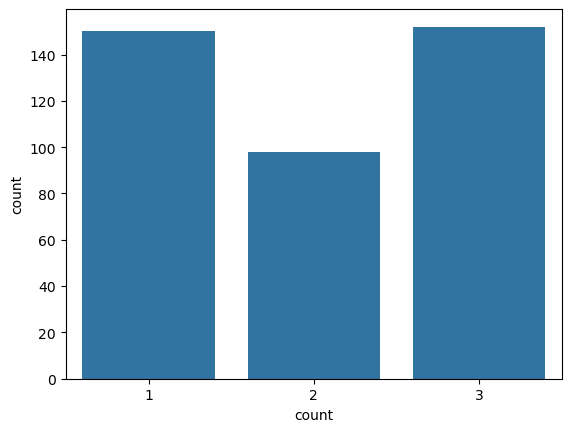

In [281]:
countDist = pd.DataFrame(sampDf["rssUrl"].value_counts())
sns.countplot(data=countDist, x="count")

In [282]:
#sanity check
sampDf.head()

,transcript,enclosure,cleanDatesLoc,epTitle,title,podDescription,epDescription,displayText,rssUrl
0,"(gentle music) Hey, it's great to see you here...",http://ehope.sermon.net/21599916/controller/li...,2020-05-30 16:50:00+00:00,You Can Run But You Can’t Hide,"Hope Church (Dubuque, IA)","Sermons from Hope Church in Dubuque, Iowa.","Sermons from Hope Church in Dubuque, Iowa.",<strong>Description:</strong><br>Sermons from ...,http://ehope.sermon.net/rss/main/audio
1,"[Music] Hey, welcome. I hope your week went we...",http://ehope.sermon.net/21595920/controller/li...,2020-05-23 21:34:00+00:00,Can You Really Run from God?,"Hope Church (Dubuque, IA)","Sermons from Hope Church in Dubuque, Iowa.","Sermons from Hope Church in Dubuque, Iowa.",<strong>Description:</strong><br>Sermons from ...,http://ehope.sermon.net/rss/main/audio
2,[Music] Hey Pastor Matt here. Glad you joined ...,http://ehope.sermon.net/21591639/controller/li...,2020-05-16 17:15:00+00:00,Your Most Important Yes,"Hope Church (Dubuque, IA)","Sermons from Hope Church in Dubuque, Iowa.","Sermons from Hope Church in Dubuque, Iowa.",<strong>Description:</strong><br>Sermons from ...,http://ehope.sermon.net/rss/main/audio
3,Welcome. Welcome to Big Valley Grace Community...,https://bigvalleygrace.s3-us-west-1.amazonaws....,2020-05-31 16:00:00+00:00,Message: BREAK THROUGH || part 3,The Big Valley Grace Podcast,The Big Valley Grace Podcast,Message: Pastor Joel Boone || Breakthrough is ...,<strong>Description:</strong><br>Message: Past...,http://feeds.feedburner.com/TheBVGPodcast
4,Welcome. Welcome to Big Valley Grace Community...,https://bigvalleygrace.s3-us-west-1.amazonaws....,2020-05-27 16:09:55+00:00,Message: BREAK THROUGH || part 2,The Big Valley Grace Podcast,The Big Valley Grace Podcast,Message: Pastor Joel Boone || Breakthrough is ...,<strong>Description:</strong><br>Message: Past...,http://feeds.feedburner.com/TheBVGPodcast


In [283]:
for dispText in list(sampDf["displayText"])[:10]: 
    print(dispText)

<strong>Description:</strong><br>Sermons from Hope Church in Dubuque, Iowa.<br><br><strong>Transcript:</strong><br>Hey, it's great to see you here today, even though I really can't see you, hopefully you can see me. But hey, we're gonna be continuing our series on Jonah. And Matt, last week Matt kind of started out the series. And as he ended it, he ended where I'm gonna be picking up where Jonah's on the ship and he's gonna get thrown off. And Matt ended it by talking about the title of, "Dump the Chump,." But I figured I would go with a little more Greek title and call it"" "You can run, but you can't hide,." And so when we think about what's going on here, the background that's going on is, Jonah has been called by God to go to Nineveh. And he's been called to go to Nineveh and to preach to these people. These people are evil people. People in Israel really did not like the Ninevehites. The Israelites really didn't like the Ninevehites at all. They were just evil people that they di

In [284]:
sampDf.to_json("/shared/3/projects/benlitterer/podcastData/annotation/400pods.jsonl", orient="records", lines=True)